<a href="https://colab.research.google.com/github/yjodev/Tobigs19/blob/main/tobigs19_Clustering_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 19기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [18]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import *
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial as sp 

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [17]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
from kneed import KneeLocator


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/투빅스/과제/Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. 데이터 전처리

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


- Gender를 제외하고 모두 int이다. 
- 클러스터링을 위해 Gender도 one-hot-encoding을 해준다.

In [5]:
df.shape

(200, 4)

In [6]:
print(df.isnull().sum())

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


- Gender에 대한 One-Hot-Encoding

In [25]:
encoder = OneHotEncoder().fit(df[['Gender']])    
encoder.get_feature_names(['Gender'])  # One-Hot-Encoding 결과 나타나는 feature명

array(['Gender_Female', 'Gender_Male'], dtype=object)

In [10]:
endcoded_data = pd.DataFrame(encoder.transform(df[['Gender']]).toarray(), index = df.index,
                             columns = encoder.get_feature_names(['Gender'])) 

data = pd.concat([df, endcoded_data], sort = False, axis = 1).drop(['Gender'], axis = 1)
data  
# One-Hot-Encoding이후 DataFrame을 구분하기 위함

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0
...,...,...,...,...,...
196,35,120,79,1.0,0.0
197,45,126,28,1.0,0.0
198,32,126,74,0.0,1.0


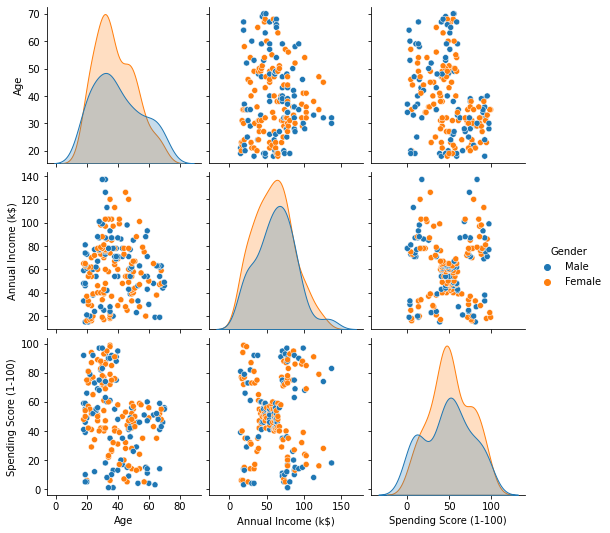

In [11]:
# Feature간의 관계를 시각화
sns.pairplot(df, hue = "Gender") # Gender에 따라 색상을 나눈다. 
plt.show()

- Annual Income과 Spending Score의 산점도 그래프에서 점들이 5개의 군집으로 나뉘는 것처럼 보인다.
- Age와 Spending Score의 산점도 그래프에서 점들이 2개의 군집으로 나뉘는 것으로 보인다.
- 두 가지 그래프를 중심으로 K-means 클러스터링 알고리즘을 이용하여 군집화해볼 것이다.

## 2. Annual Income (k$), Spending Score (1-100) 군집화


In [12]:
# data에서 Annual Income (k$), Spending Score (1-100) column만 추출

data_1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]
data_1

,Annual Income (k$),Spending Score (1-100)
CustomerID,,
1,15,39
2,15,81
3,16,6
4,16,77
5,17,40
...,...,...
196,120,79
197,126,28
198,126,74


### Scaling

In [13]:
# data_1 스케일링

scaler = StandardScaler()
scaler.fit(data_1)
data_1 = pd.DataFrame(scaler.transform(data_1))     # 스케일링한 데이터를 다시 DataFrame으로
data_1

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


### 최적 K 찾기

In [26]:
# Elbow_graph: 클러스터 개수 변화에 따른 SSE  
def Elbow_graph(K, data):
    SSE = []
    k = 1
    while 1 <= k <= K:
        k_means = KMeans(n_clusters = k)     # 클러스터 개수가 k개인 모델 생성
        k_means.fit(data_1)
        SSE.append(k_means.inertia_)     # inertia : sum of squared distances of samples to their closest cluster center
        k += 1
     
    plt.plot(range(1, K+1), SSE, 'o')     # K값에 따른 SSE 표시
    plt.plot(range(1, K+1), SSE, '--')     # SSE값을 연결하는 직선 그리기
    plt.xlabel('K')
    plt.ylabel('SSE')
    kn = KneeLocator(range(1, K+1), SSE, curve = 'convex', direction = 'decreasing')     # Elbow Point 찾기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles = 'dashed')     # Elbow Point를 수직선으로 표시
    return SSE


[400.00000000000006,
 270.1559035072793,
 157.7040081503594,
 108.92131661364358,
 65.56840815571681,
 55.10377812115058,
 44.91118554999014,
 37.207705015742285,
 32.82802898718322,
 29.33716549866677,
 25.905865152509055]

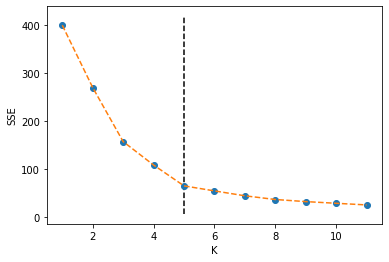

In [28]:
Elbow_graph(K = 11, data = data_1)


Elbow graph가 꺾이는 부분인 K=4로 설정하는 것이 적절하다.

### Fitting

In [29]:
k_means = KMeans(n_clusters = 4).fit(data_1)

data['k=4'] = k_means.labels_     # labels_ : Labels of each point
# 각 행이 어느 군집으로 분류되었는지 확인할 수 있도록 'k=4' column 추가

data



,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5,k(4)
CustomerID,,,,,,,,
1,19,15,39,0.0,1.0,3,4,3
2,21,15,81,0.0,1.0,2,2,0
3,20,16,6,1.0,0.0,3,4,3
4,23,16,77,1.0,0.0,2,2,0
5,31,17,40,1.0,0.0,3,4,3
...,...,...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,0,0,1
197,45,126,28,1.0,0.0,1,1,2
198,32,126,74,0.0,1.0,0,0,1


### 시각화

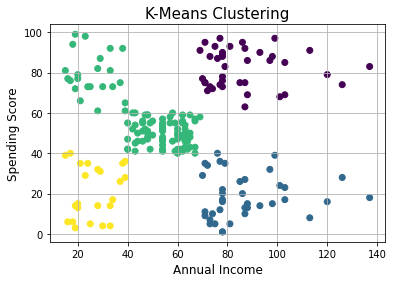

In [22]:

plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=4'])
plt.xlabel("Annual Income", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

- 그런데, 사람의 눈으로 보기에 Annual Income과 Spending Score이 중간인 군집을 따로 두어 총 5개의 군집으로 두는 것이 좋아보인다. 

In [30]:
k_means = KMeans(n_clusters = 5).fit(data_1)

data['k=5'] = k_means.labels_
data

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5,k(4)
CustomerID,,,,,,,,
1,19,15,39,0.0,1.0,3,3,3
2,21,15,81,0.0,1.0,2,1,0
3,20,16,6,1.0,0.0,3,3,3
4,23,16,77,1.0,0.0,2,1,0
5,31,17,40,1.0,0.0,3,3,3
...,...,...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,0,2,1
197,45,126,28,1.0,0.0,1,4,2
198,32,126,74,0.0,1.0,0,2,1


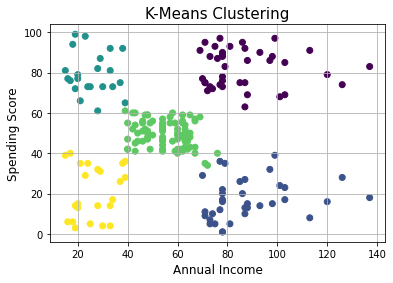

In [24]:
# K = 5일 때 K-Means Clustering의 결과를 시각화

plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=5'])
plt.xlabel("Annual Income", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

## 3. Age, Spending Score (1-100) 군집화


In [31]:
data_2 = data[['Age', 'Spending Score (1-100)']]
data_2

,Age,Spending Score (1-100)
CustomerID,,
1,19,39
2,21,81
3,20,6
4,23,77
5,31,40
...,...,...
196,35,79
197,45,28
198,32,74


### Scaling

In [32]:
scaler = StandardScaler()
scaler.fit(data_2)
data_2 = pd.DataFrame(scaler.transform(data_2))     # 스케일링한 데이터를 다시 DataFrame으로
data_2

,0,1
0,-1.424569,-0.434801
1,-1.281035,1.195704
2,-1.352802,-1.715913
3,-1.137502,1.040418
4,-0.563369,-0.395980
...,...,...
195,-0.276302,1.118061
196,0.441365,-0.861839
197,-0.491602,0.923953
198,-0.491602,-1.250054


### 최적 K 찾기

[400.00000000000006,
 270.70426664306717,
 157.7040081503594,
 108.92131661364358,
 65.56840815571681,
 55.10377812115058,
 44.86475569922557,
 37.199523875977086,
 32.44865134833634,
 29.11556455754576,
 25.905865152509055]

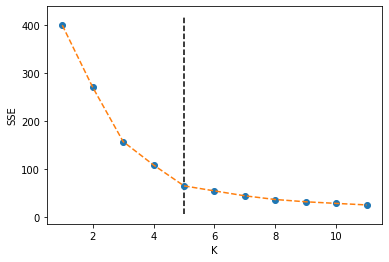

In [33]:
SSE_graph(K = 11, data = data_2)

### Fitting

In [34]:
k_means = KMeans(n_clusters = 5).fit(data_2)

data['k=5_2'] = k_means.labels_
data

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5,k(4),k=5_2
CustomerID,,,,,,,,,
1,19,15,39,0.0,1.0,3,3,3,1
2,21,15,81,0.0,1.0,2,1,0,0
3,20,16,6,1.0,0.0,3,3,3,4
4,23,16,77,1.0,0.0,2,1,0,0
5,31,17,40,1.0,0.0,3,3,3,1
...,...,...,...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,0,2,1,0
197,45,126,28,1.0,0.0,1,4,2,4
198,32,126,74,0.0,1.0,0,2,1,0


### 시각화

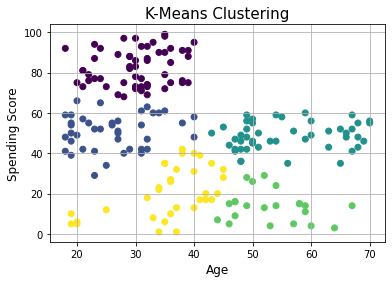

In [35]:
plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Age'], data['Spending Score (1-100)'], c = data['k=5_2'])
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

## 평가

### Dunn's Index

클러스터링의 목표를 상기해보자.
-  군집 간 분산(inter-cluster variance) 최대화
-  군집 내 분산(inner-cluster variance) 최소화

이를 측정하기 위한 지표 중 하나인 Dunn's Index는 군집 간 거리의 최소값(하단 좌측)을 분자, 군집 내 요소 간 거리의 최대값(하단 우측)을 분모로 하는 지표.

𝐼(𝐶)=min𝑖≠𝑗{𝑑𝑐(𝐶𝑖,𝐶𝑗)}/max1≤𝑙≤𝑘{△(𝐶𝑙)}

군집 간 거리는 멀수록, 군집 내 분산은 작을 수록 좋은 군집화 결과라 말할 수 있는데, 이 경우에 Dunn Index는 커지게 된다.

#### 클러스터내 거리측도: Complete Diameter Distance

In [37]:
from itertools import combinations

def complete_diameter_distance(X):
    res = []
    for i, j in combinations(range(X.shape[0]),2):
        a_i = X[i, :]
        a_j = X[j, :]
        res.append(np.linalg.norm(a_i-a_j))
 
    return np.max(res)

#### 클러스터간 거리측도: Single Linkage Distance

In [36]:
def single_linkage_distance(X1, X2):
    res = []
    for x1 in X1:
        for x2 in X2:
            res.append(np.linalg.norm(x1-x2))
    return np.min(res)

### Dunn's index 구하기

In [38]:
def get_Dunn_index(X, labels, intra_cluster_distance_type, 
                   inter_cluster_distance_type):
 
    intra_cdt_dict = {
        'cmpl_dd':complete_diameter_distance
    }
    inter_cdt_dict = {
        'sld' : single_linkage_distance
    }
    # intra cluster distance
    intra_cluster_distance = intra_cdt_dict[intra_cluster_distance_type] 
 
    # inter cluster distance
    inter_cluster_distance = inter_cdt_dict[inter_cluster_distance_type]
 
    # get minimum value of inter_cluster_distance
    res1 = []
    for i, j in combinations(np.unique(labels),2):
        X1 = X[np.where(labels==i)[0], :]
        X2 = X[np.where(labels==j)[0], :]
        res1.append(inter_cluster_distance(X1, X2))
    min_inter_cd = np.min(res1)
 
    # get maximum value of intra_cluser_distance
 
    res2 = []
    for label in np.unique(labels):
        X_target = X[np.where(labels==label)[0], :]
        if X_target.shape[0] >= 2:
            res2.append(intra_cluster_distance(X_target))
        else:
            res2.append(0)
    max_intra_cd = np.max(res2)
 
    Dunn_idx = min_inter_cd/max_intra_cd
    return Dunn_idx

In [55]:
intra_cluster_distance_type = 'cmpl_dd'
inter_cluster_distance_type = 'sld'

X=data_1.to_numpy()
label = data['k=5'].to_numpy()

get_Dunn_index(X, label, intra_cluster_distance_type, inter_cluster_distance_type)

0.05940477803838099

In [57]:
label = data['k=4'].to_numpy()
get_Dunn_index(X, label, intra_cluster_distance_type, inter_cluster_distance_type)

0.0

In [56]:
X=data_2.to_numpy()
label = data['k=5_2'].to_numpy()
get_Dunn_index(X, label, intra_cluster_distance_type, inter_cluster_distance_type)

0.1069404336000662

Dunn's Index 
- Annual Income과 Spending Score를 네 개의 군집으로 분류한 결과: 0.0
- Annual Income과 Spending Score를 다섯 개의 군집으로 분류한 결과: 0.0594
- Age와 Spending Score를 네 개의 군집으로 분류한 결과: 0.1069

1에 가까울수록 클러스터링이 잘 되었다고 판단할 수 있다. 세 가지 분류 모두 매우 낮은 결과를 보인다 ...(Dunn's Index 계산이 잘못된 것 같다)